# Using yt and mplot3d to visualize the 3D shock-bubble problem

This notebook shows how to plot slices and isosurfaces of a PyClaw simulation using yt and mplot3d, with the Sedov problem as an example.  To execute the notebook, you should first run the shock-bubble example in the same directory where the notebook is located.  You also need to have [installed yt](http://yt-project.org/#getyt).

First we'll import what we need from yt and from pyclaw.  We'll also set which frame to plot and whether we want to plot the full solution or just the quadrant in which it is computed (in the simulation, we use the symmetry of the problem to reduce the computational domain by a factor of 4).

In [1]:
import yt
from clawpack.pyclaw import Solution
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
import matplotlib.pyplot as plt

frame = 4 # Frame to plot (0-10)
plot_all_quadrants = False  # If True, reflect data to plot all four y-z plane quadrants

Next we load one frame of the solution from a file on disk.

In [2]:
# Load solution
sol = Solution(frame,path='./_output/',file_format='hdf', file_prefix="claw");

The next two cells reflect the data (if we want to plot all 4 quadrants) and set up the data structures yt expects.

In [3]:
x,y,z = sol.grid.dimensions

if plot_all_quadrants:
    # Reflect solution in y and z
    y_reflection = sol.q[:,:,::-1,:]
    double = np.concatenate((y_reflection,sol.q),2)
    z_reflection = double[:,:,:,::-1]
    full = np.concatenate((z_reflection,double),3)
    bbox = np.array([[x.lower,x.upper],[-y.upper,y.upper],[-z.upper,z.upper]])
else:
    full = sol.q
    bbox = np.array([[x.lower,x.upper],[y.lower,y.upper],[z.lower,z.upper]])

In [4]:
# Set up field dictionary that yt expects
data = {'Density'    : full[0,:,:,:],
        'x-momentum' : full[1,:,:,:],
        'y-momentum' : full[2,:,:,:],
        'z-momentum' : full[3,:,:,:],
        'Energy'     : full[4,:,:,:]}

In [5]:
pf = yt.load_uniform_grid(data,full[0,:,:,:].shape, 1, bbox=bbox)

yt : [INFO     ] 2024-12-04 18:17:43,118 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-12-04 18:17:43,119 Parameters: domain_dimensions         = [256  64  64]
yt : [INFO     ] 2024-12-04 18:17:43,120 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-12-04 18:17:43,121 Parameters: domain_right_edge         = [2.  0.5 0.5]
yt : [INFO     ] 2024-12-04 18:17:43,122 Parameters: cosmological_simulation   = 0


## Cut-plane

Next, let's plot a cut-plane.  For some reason the plot's x-axis seems to be reversed.  If you are more of a yt expert and can correct this, please let me know!

This is adapted from http://yt-project.org/doc/cookbook/complex_plots.html#plotting-isocontours.

yt : [INFO     ] 2024-12-04 18:17:46,423 xlim = -0.250000 0.250000
yt : [INFO     ] 2024-12-04 18:17:46,424 ylim = -0.250000 0.250000
yt : [INFO     ] 2024-12-04 18:17:46,427 Making a fixed resolution buffer of (('stream', 'Density')) 800 by 800



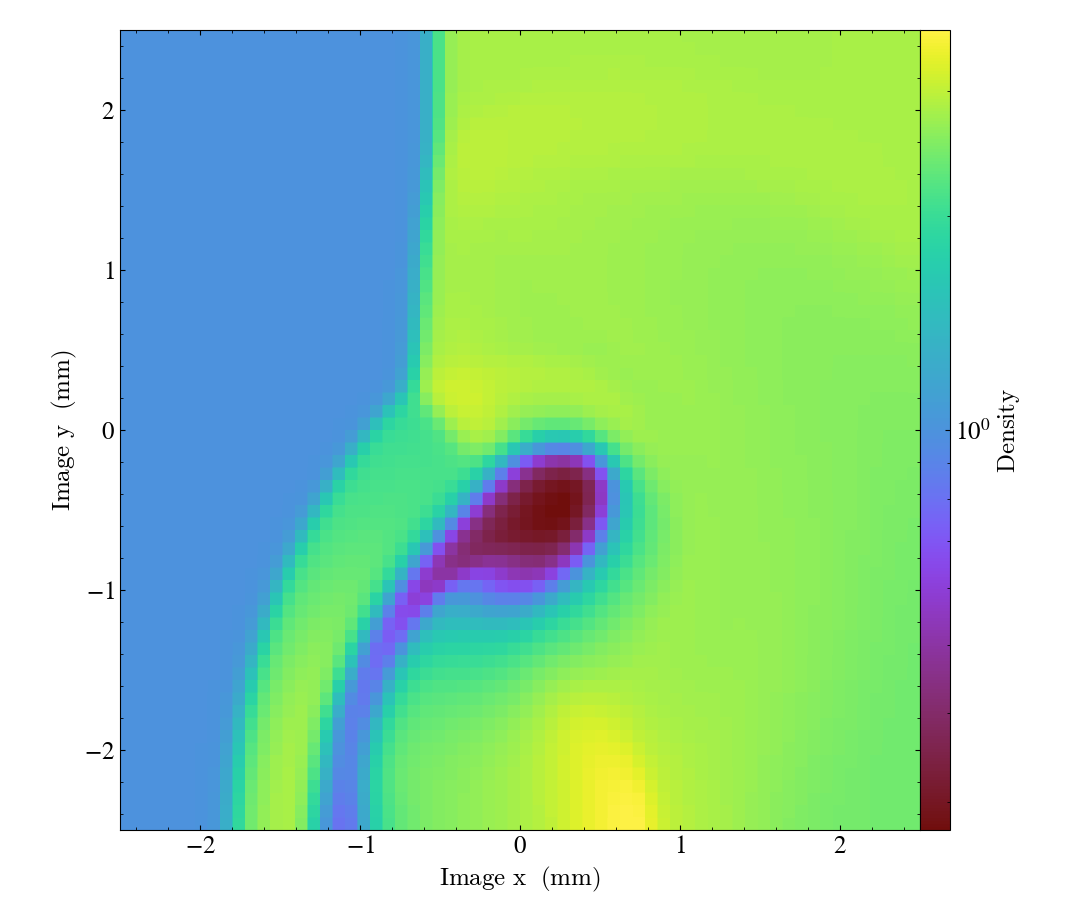

In [6]:
# Plot a cut plane: specify normal vector and center, in that order
cp = pf.cutting([0.0, 1.0, 0.0], [0.75,0.,0.25])
pw = cp.to_pw(fields = ["Density"])
pw.show()

In [7]:
pf.field_list

[('stream', 'Density'),
 ('stream', 'Energy'),
 ('stream', 'x-momentum'),
 ('stream', 'y-momentum'),
 ('stream', 'z-momentum')]

In [8]:
pf.print_stats()

level	# grids	       # cells	     # cells^3
----------------------------------------------
  0	     1	       1048576	           102
----------------------------------------------
   	     1	       1048576


t = 0.00000000e+00 code_time = 0.00000000e+00 s = 0.00000000e+00 yr

Smallest Cell:
	Width: 2.532e-27 Mpc
	Width: 2.532e-21 pc
	Width: 5.222e-16 AU
	Width: 7.812e-03 cm


In [9]:
slc = yt.SlicePlot(pf, "y", ("stream", "Density"))

yt : [INFO     ] 2024-12-04 18:17:55,494 xlim = 0.000000 0.500000
yt : [INFO     ] 2024-12-04 18:17:55,494 ylim = 0.000000 2.000000
yt : [INFO     ] 2024-12-04 18:17:55,497 xlim = 0.000000 0.500000
yt : [INFO     ] 2024-12-04 18:17:55,498 ylim = 0.000000 2.000000
yt : [INFO     ] 2024-12-04 18:17:55,499 Making a fixed resolution buffer of (('stream', 'Density')) 800 by 800



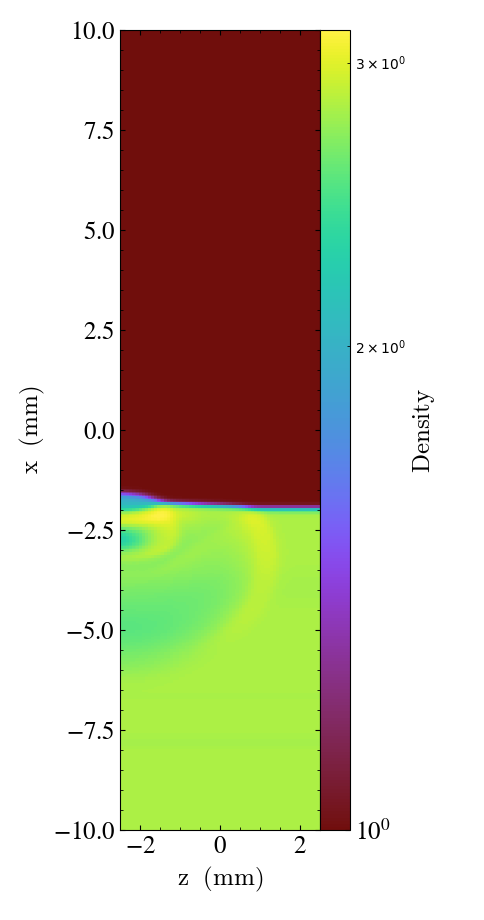

In [10]:
slc.show()

## Isosurface

Next we construct an isosurface and use mplot3d to plot it.  We'll take a density isosurface and color it based on energy.

In [11]:
sphere = pf.sphere([0.65,0.0,0.0], 0.3) # Restrict to a sphere for visibility purposes
surface = pf.surface(sphere,"Density",0.4)  # construct an isosurface

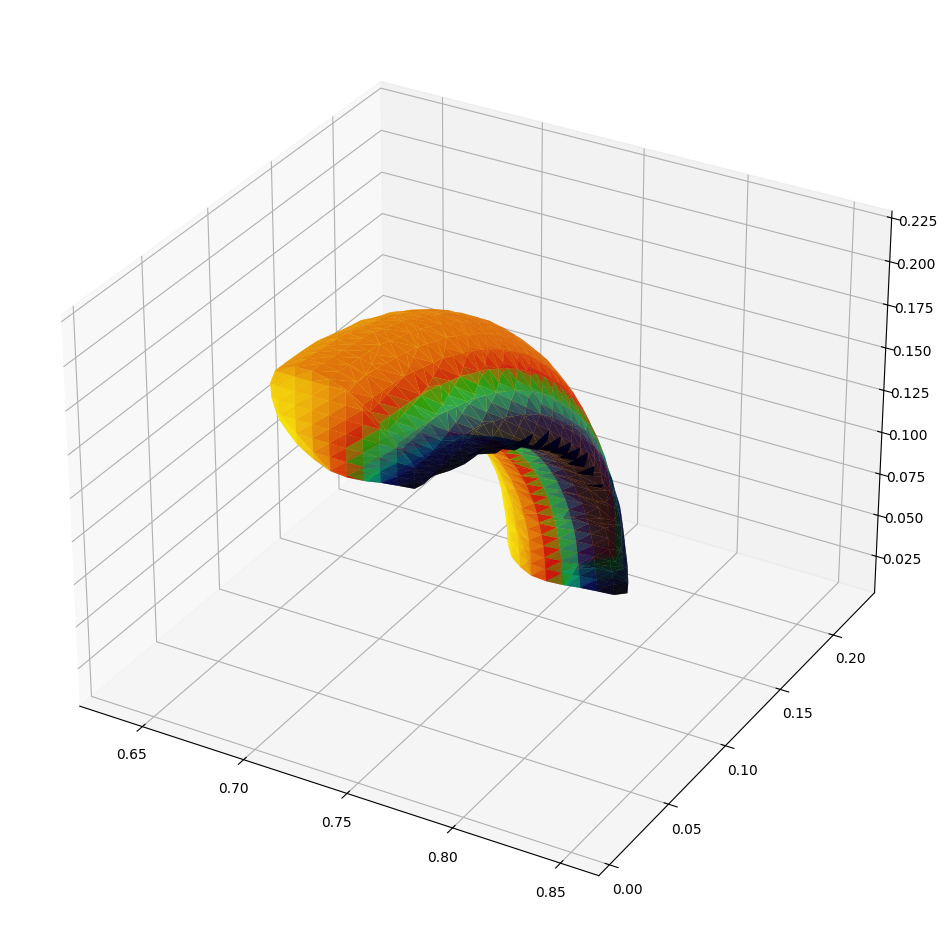

In [13]:
colors = yt.apply_colormap(np.log10(surface["Energy"]), cmap_name="BLUE")

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='3d')
p3dc = Poly3DCollection(surface.triangles, linewidth=0.01,alpha=0.8)
p3dc.set_facecolors(colors[0,:,:]/255.)
ax.add_collection(p3dc)
max_extent = (surface.vertices.max(axis=1) - surface.vertices.min(axis=1)).max()
centers = (surface.vertices.max(axis=1) + surface.vertices.min(axis=1)) / 2
bounds = np.zeros([3,2])
bounds[:,0] = centers[:] - max_extent/2
bounds[:,1] = centers[:] + max_extent/2
ax.auto_scale_xyz(bounds[0,:], bounds[1,:], bounds[2,:])